# Multivariate Exploratory Data Analysis: Combo Charts and Heat Maps
---
## Purpose:
In the last notebook (Univariate EDA) we explored base distributions in our 3 datasets from the EPA, USDA, and Redfin to identify how are data is skewed at the county and state level. We also looked at the top and bottom 5 states for factors like emissions, income, and property values. <u>In this notebook, we will begin multivariate analysis to answer our project's core questions</u> which are listed below. 

1. Are factors of wealthy, population density, and inequality correlated with pollution levels?
2. Which areas generate the greatest residental pollution relative to local income? 
3. Which regions have the greatest residental pollution relative to their property values? 
4. How are pollution compositions stratified across sectors when we look at different groups of people? 


### Package Installation and Versioning Requirments:
For questions regarding python version, package installations, and other functional requirements, see the *Read Me* file contained [here](link).

Now, let's begin.

### Import Packages and Load Data

In [145]:
#importing required packages: 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# Importing py files
from Basic_data_structure import *
from Data_manipulation import *
from Univariate_EDA import get_extremes
# Load the dataframes
global df_emissions, df_USDA, df_Redfin
df_emissions, df_USDA, df_Redfin = load_base_data()

# Clean the county-level dataframes, focusing on residential emissions
df_Redfin_County = Clean_Redfin(df_Redfin, "COUNTY")
df_USDA_County = Clean_USDA(df_USDA, "COUNTY")
df_emissions_County = Clean_EPA(df_emissions, "COUNTY", "residential", agg=True)

# Clean the state-level dataframes, focusing on residential emissions
df_Redfin_State = Clean_Redfin(df_Redfin, "STATE")
df_USDA_State = Clean_USDA(df_USDA, "STATE")
df_emissions_State = Clean_EPA(df_emissions, "STATE", "residential", agg=True)

#Get Merged Dataframes to work with 
df_merged_state = get_merge_df(df_emissions_State,df_USDA_State,df_Redfin_State, level="STATE")
df_merged_cty = get_merge_df(df_emissions_County,df_USDA_County,df_Redfin_County, level="COUNTY")

### Multivariate Analysis: Pollution to Income Ratio

in the following segment, we're going to address the following questions:
* "Which areas generate the greatest residental pollution relative to local income?"
* "Which areas generate the greatest residental pollution relative to property value?"

In [146]:
# We'll start by creating a new emissions column, normalizing the emissions to the civilian labor force. 
# it's not a perfect match to the true population since it excludes children, elderly, and individuals with disabilities 
# that cannot work. However, we were limited to 3 datasets for this project, so we are assuming for now that the labor
# force is roughly the size of the population. 

# Normalize pollution at the person level, and convert from tons to lbs of CO emissions:
df_merged_state["Emissions per Person"] = df_merged_state["EMISSIONS"] / df_merged_state["Civilian_labor_force_2021"] *2000
df_merged_cty["Emissions per Person"]   = df_merged_cty["EMISSIONS"]   / df_merged_cty["Civilian_labor_force_2021"] *2000

# Now let's find the ratio of per-person CO pollution to income
df_merged_state["PI_ratio"] = df_merged_state["Emissions per Person"] / df_merged_state["Median_Household_Income_2021"]
df_merged_cty["PI_ratio"]   = df_merged_cty["Emissions per Person"]   / df_merged_cty["Median_Household_Income_2021"] 

# And let's snag the ratio of per-person CO pollution to property value
df_merged_state["PPV_ratio"] = df_merged_state["Emissions per Person"] / df_merged_state["median_sale_price"]
df_merged_cty["PPV_ratio"]   = df_merged_cty["Emissions per Person"]   / df_merged_cty["median_sale_price"] 

In [147]:
df_merged_state.head(2)

,STATE,STATE FIPS,EMISSIONS,Civilian_labor_force_2021,Median_Household_Income_2021,Unemployment_rate_2021,median_sale_price,state,Emissions per Person,PI_ratio,PPV_ratio
0,AL,01,406246,4518704.0,55206.166292,3.377170,200000.0,Alabama,179.806422,0.003257,0.000899
1,AK,02,249777,706316.0,79244.605215,6.409494,317350.0,Alaska,707.267002,0.008925,0.002229


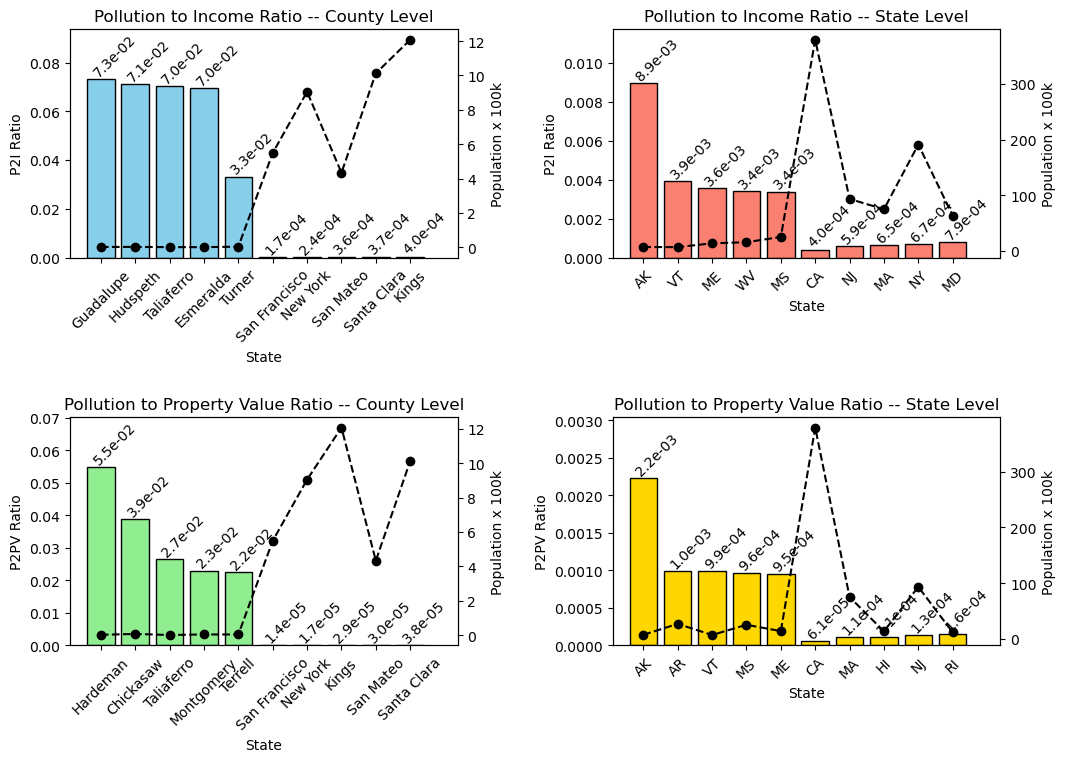

In [148]:
# next to see the places with highest/lowest pollution to income and pollution to property values, let's 
# call the get_extremes function from our univariate analysis. 
county_extremes_PI = get_extremes(df_merged_cty, "PI_ratio")
county_extremes_PPV = get_extremes(df_merged_cty, "PPV_ratio")

state_extremes_PI = get_extremes(df_merged_state, "PI_ratio")
state_extremes_PPV = get_extremes(df_merged_state, "PPV_ratio")

# and let's go ahead and plot these to find out.  
def extremes_bar_plotter(dfs):
    
    # Set the figure object, while providing a numpy array of axis (our 2x2 matrix)
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    titles = ["Pollution to Income Ratio -- County Level", "Pollution to Income Ratio -- State Level", 
              "Pollution to Property Value Ratio -- County Level", "Pollution to Property Value Ratio -- State Level"]
    ylabels = ["P2I Ratio", "P2I Ratio", "P2PV Ratio", "P2PV Ratio"]
    colors = ['skyblue', 'salmon', 'lightgreen', 'gold']
    columns = ["PI_ratio", "PI_ratio", "PPV_ratio", "PPV_ratio"]
    divisor = [1, 1, 1, 1]
    locations = ["COUNTY", "STATE", "COUNTY", "STATE"]
    
    # We're going to iterate through each of the 4 dataframes, and assign the proper title, label, coloring, and 
    # scaling factor using the zip method on our flattened list of subplots. 
    for ax, df, title, ylabel, color, column, div, location in zip(axs.flat, dfs, titles, ylabels,
                                                         colors, columns, divisor, locations):
        #set indices for the states (our x range)
        indices = np.arange(len(df)) 
        bars = ax.bar(indices, df[column] / div, color=color, edgecolor='black',width=.8) 
        # Set x-ticks at bar positions
        ax.set_xticks(indices)  
        # Set x-tick labels to the state
        ax.set_xticklabels(df[location], rotation=45)  
        ax.set_title(f'{title}')
        ax.set_ylabel(ylabel)
        ax.set_xlabel("State")
        
        ax2 = ax.twinx()
        ax2.plot(indices, df["Civilian_labor_force_2021"]/100000, 'ko--')
        ax2.set_ylabel('Population x 100k', color='k')        
        
        for bar, value in zip(bars, df[column] / div):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 1, height, f'{value:.1e}', ha='center', va='bottom',fontsize=10, 
                    rotation=45)        

    max_height = ax.get_ylim()[1]
    height_adjustment = [40,5,30, 1.3]
    max_len = ax.get_xlim()[1]
    len_adjustment = [1.05 for i in range(4)]
    counter = 0
    for ax in axs.flat:
        ax.set_ylim(top=max_height * height_adjustment[counter])
        ax.set_xlim(right=max_len * len_adjustment[counter])
        counter +=1
    plt.subplots_adjust(hspace=0.7, wspace=0.4)

extreme_dfs = [county_extremes_PI, state_extremes_PI, county_extremes_PPV, state_extremes_PPV]
extremes_bar_plotter(extreme_dfs)

In [151]:
# Okay, so this is interesting. We see clearly that at the state level and at the county level, the locations with the
# greatest pollution relative to income are those which boast smaller populations, whilethose with the smallest 
# pollution to income ratios have quite large populations. 

# It's worth noting that the counties with the lowest pollution to income also have the lowest pollution to property 
# value. We see slight changes to this at the state level (swapping Maryland and New York for Hawaii and Rhode Island),
# but at the county level, the highest ratios are entirely different counties.

# We might be tempted to suggest that all small population areas have large rates of pollution to income or 
# property values, but we know by the law of small numbers that small sample sets can skew our representation. There's 
# likely a few low-population counties with very small pollution relative to income or property value.

# If we want to identify if there's a clear correlation between population density (rural vs urban), we can do this by
# making a correlation matrix or a SPLOM. For this project, we'll use a correlation matrix -- and we'll do that now. 

In [152]:
df_merged_cty

,STATE,STATE FIPS,COUNTY FIPS,COUNTY,Rural_Urban_Continuum_Code_2013,EMISSIONS,Civilian_labor_force_2021,Median_Household_Income_2021,Unemployment_rate_2021,median_sale_price,Emissions per Person,PI_ratio,PPV_ratio
0,AL,01,007,Bibb,1.0,1778,8641.0,48454.0,3.4,186750.0,411.526444,0.008493,0.002204
1,AL,01,009,Blount,1.0,4400,25377.0,56894.0,2.4,194250.0,346.770698,0.006095,0.001785
2,AL,01,015,Calhoun,3.0,8920,46368.0,48166.0,4.0,156100.0,384.748102,0.007988,0.002465
3,AL,01,019,Cherokee,6.0,2232,11686.0,46365.0,2.5,211475.0,381.995550,0.008239,0.001806
4,AL,01,021,Chilton,1.0,4939,20004.0,55142.0,2.8,193000.0,493.801240,0.008955,0.002559
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1775,WI,55,133,Waukesha,1.0,19452,223477.0,94506.0,3.2,365750.0,174.085029,0.001842,0.000476
1776,WI,55,135,Waupaca,6.0,5727,25835.0,63216.0,3.6,172750.0,443.352042,0.007013,0.002566
1777,WI,55,137,Waushara,6.0,3252,11296.0,57188.0,4.3,188778.0,575.779037,0.010068,0.003050
1778,WI,55,139,Winnebago,3.0,11542,92137.0,64640.0,3.3,187450.0,250.539957,0.003876,0.001337


### Correlation Matrix


In [278]:
# We're going to encode our emissions per person column to normalize for locations which are skewed by large areas or 
# populations. 
def plot_correlations(df, include_continuum=True):
    """This function creates a correlation plot of the merged dataframe between per person CO emissions and variables
    like income, unemployment, property value, level of urbanization (Rural urban contiuum code). The user inputs
    whether or not the entire continuum is included to adjust the number of sqaures in the heatmap."""
    label_encoder_y = LabelEncoder()
    df['Encoded Emissions per Person'] = label_encoder_y.fit_transform(df['Emissions per Person'])

    correlation_list = ["Emissions per Person", "Civilian_labor_force_2021", 
                               "Median_Household_Income_2021", "Unemployment_rate_2021", "median_sale_price",
                               "Rural_Urban_Continuum_Code_2013"]
    
    if include_continuum == False:
        correlation_list = correlation_list[0:-1]
        print(correlation_list)
    elif include_continuum != True:
        raise ValueError("include_continuum must be boolean True or False") 
    
    # Make a list of columns to correlate to the Emissions per person value
    corr_cols = df[correlation_list]
    
    # Run correlation calculations on the dataframe
    corr = corr_cols.corr()

    plt.figure(figsize=(18, 10))

    # Plot the correlation heatmap using seaborn, cividis for colorblind, and setting to 2 decimal places.
    sns.heatmap(corr, annot=True, cmap='cividis', fmt='.2f')

    #Make x labels reader friendly
    custom_ticklabels = ["Emissions \nper Person", "Civilian \nLabor Force", 
                          "Median \nHousehold Income", "Unemployment \nRate", "Median \nHome Price",
                          "Rural vs. Urban \nContinuum"]

    if include_continuum == False:
        custom_ticklabels = custom_ticklabels[0:-1]
    
    plt.xticks(ticks=range(len(custom_ticklabels)), labels=custom_ticklabels, fontsize=14, ha='left', rotation=0)
    plt.yticks(ticks=range(len(custom_ticklabels)), labels=custom_ticklabels, fontsize=14, va='center')

    # Set x-label font size
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if include_continuum == False: 
        _string = "for RUC Code {}".format(int(df["Rural_Urban_Continuum_Code_2013"].iloc[0]))
    else: 
        _string = ""
    # Add a title
    plt.title("Correlation of CO Emissions (per person) {}".format(
        _string), fontsize=22)

    plt.show()
    return() 


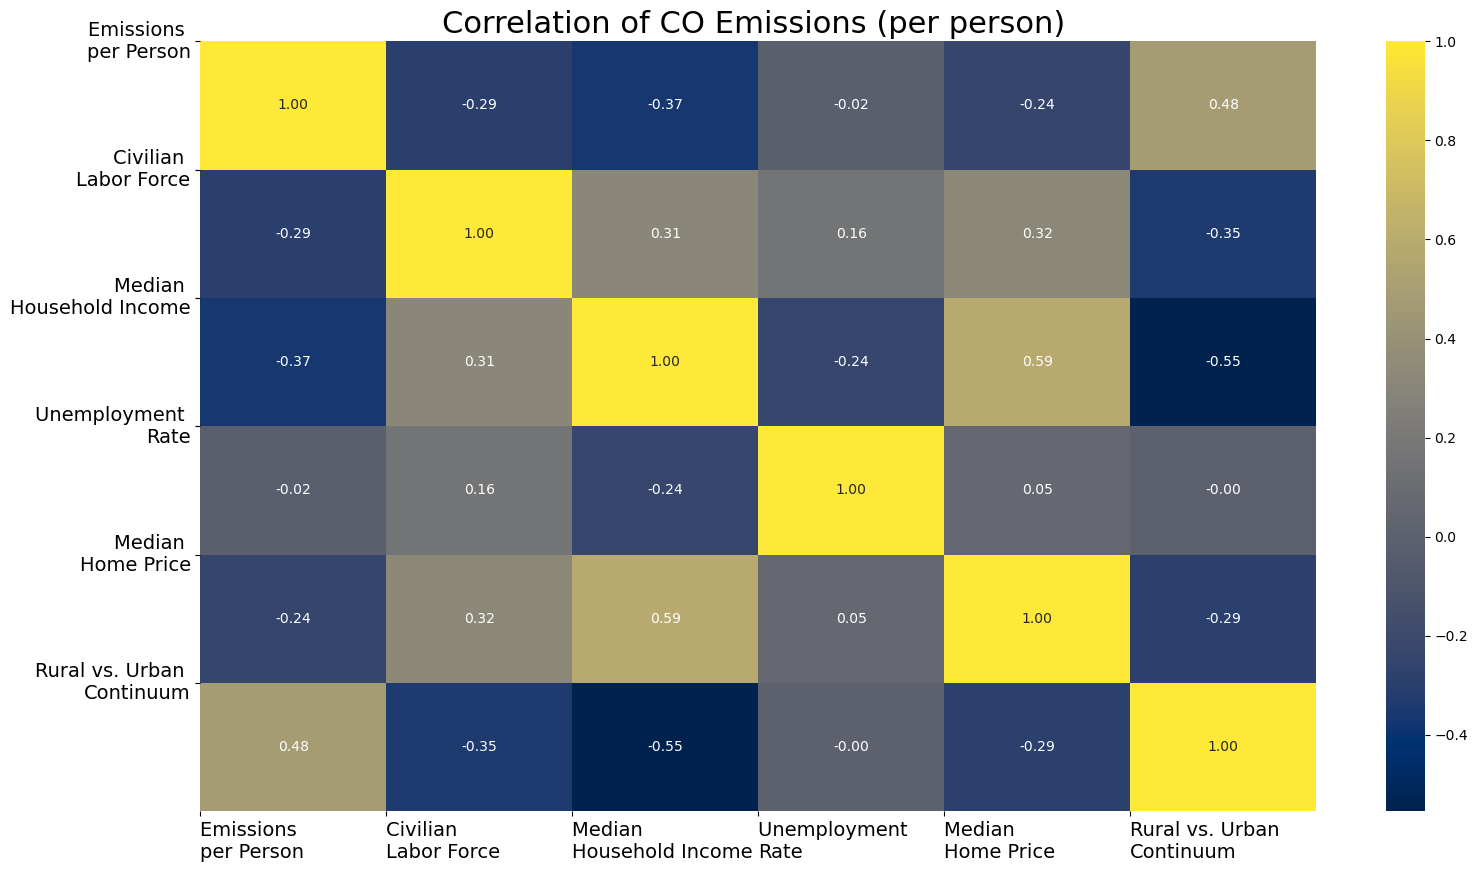

()

In [279]:
plot_correlations(df_merged_cty, include_continuum=True)

In [280]:
# So this is really interesting. When we examine the various factors that could influence residential CO pollution 
# rates, it seems that the strongest correlative factor is the degree to which the location is in a rural or urban area 
# (Rural vs. Urban Continuum), where the higher the value or more rural the area, the greater the level of pollution 
# per person. This is suppported by the labor force variable which is negatively correlated with per person pollution.

# When we consider wealth factors like income, and property value, it actually seems like pollution decreases as wealth 
# increases, but we should verify that this is true when considering locations of similar population size and proximity
# to metropolitan regions. 

# We'll do this by slicing the dataframe for a specific continuum level, to confirm if we see the name negative 
# correlations for pollution and income when considering a specific rural/metro designation.

['Emissions per Person', 'Civilian_labor_force_2021', 'Median_Household_Income_2021', 'Unemployment_rate_2021', 'median_sale_price']


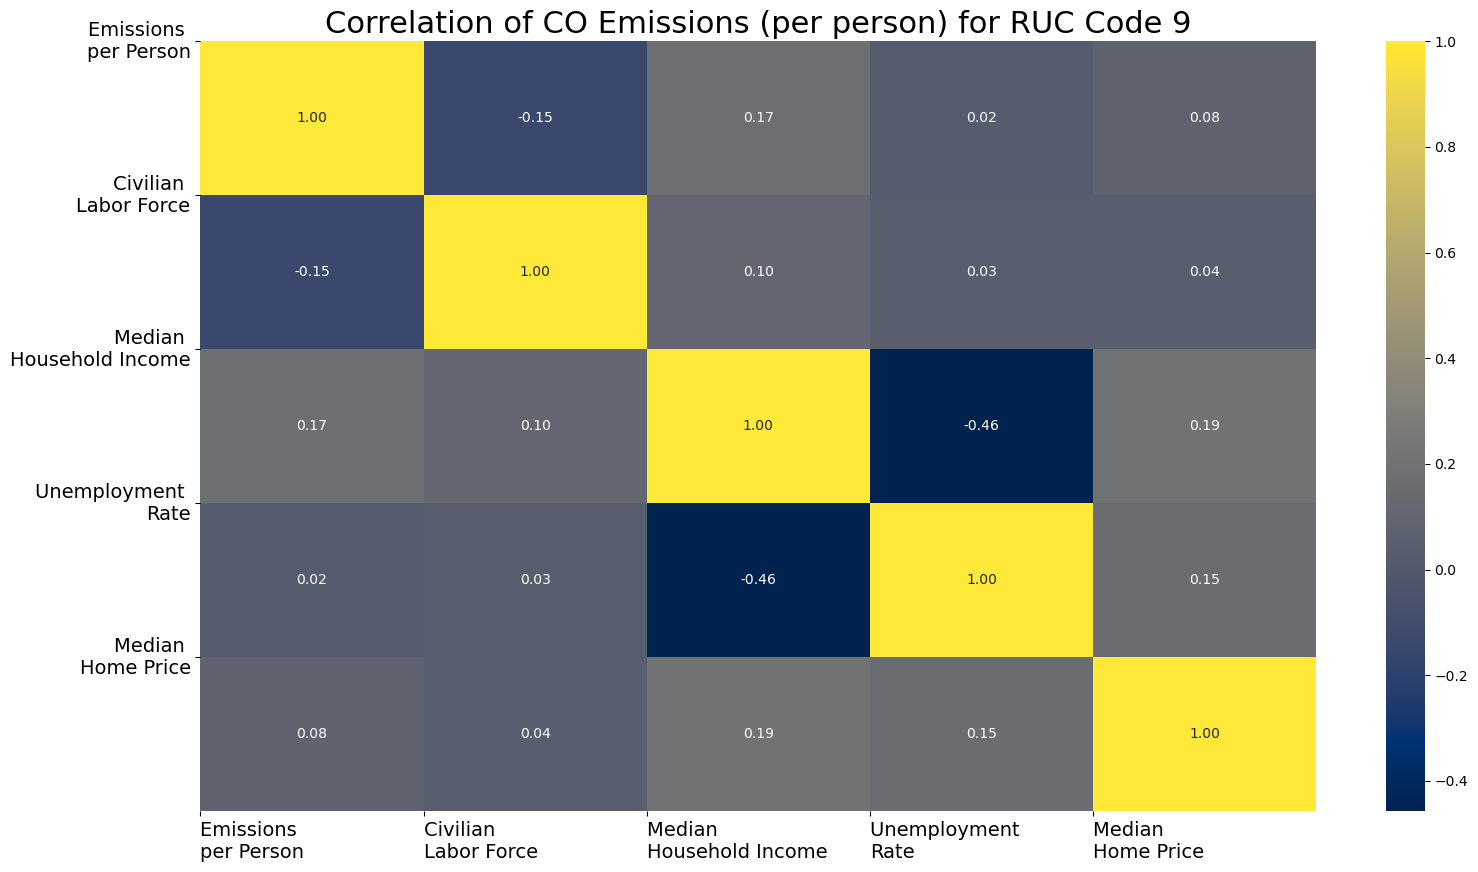

()

In [283]:
sliced_cty_df = df_merged_cty[df_merged_cty["Rural_Urban_Continuum_Code_2013"] == 9 ].copy(deep=True)
plot_correlations(sliced_cty_df, include_continuum=False)

In [284]:
# So this is really interesting. The only instance in which median household income at the county level is positively 
# correlated with CO pollution generation is when the they live in the most isolated areas of the United States, where
# the rural continuum code (9) corresponds with less than 5,000 people present, and not adjacent to a metropolitan area. 

# Other than that, in aggregate we see residential emissions for the general public are negatively correlated with income. 
# Importantly though, that's not to say that wealthy people are generally more environmentally friendly than poor people. 
# Remember that incentives have existed for years, where wealthier individuals have been taking advantage of emission 
# reducing technologies at a frequency greater than their peers. 

# Likewise, our analysis does not include air emissions. We do this because we do not have the resolution to de-couple 
# emissions from freight and corporate travel from public leisure travel.  

In [285]:
# Now we still haven't answered our last question. How are emissions stratified by sector for different populations? 
# Perhaps we'll see unique differences in pollution rates between wealthier and poorer locations when we stratify this. 
# In the next notebook, we're going to probe this, as well as geographical distributions of pollution by the various 
# factors. 

### End of Notebook

Next notebook: Multivariate Analysis: Sectoral Distributions and Geographic Choropleths

---